In [2]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad

%matplotlib inline

# Operator Variational Inference
### by R. Ranganath, J. Altosaar, D. Tran, and D. Blei (https://arxiv.org/abs/1610.09033)

Variational inference (VI) refers to the task of optimizing the parameters of a distribution such that it approximates an intractable one well.  Because Bayesian posteriors are intractable in all but the simplest cases, VI is usually employed for Bayesian models as a scalable alternative to MCMC.  The optimization objective is usually chosen as the KL-Divergence from the approximate distribution to the intractable one (although there are less-popular alternatives): $$KLD[q(\theta) \mid \mid p(\theta|\mathcal{D})] = \int_{\theta} q(\theta) [\log q(\theta) - \log p(\theta|\mathcal{D})] d\theta = \int_{\theta} q(\theta) [\log q(\theta) - \log p(\mathcal{D}, \theta)] d\theta + \log p(\mathcal{D}).$$  Rearranging the above to put the model evidence on the LHS, we have $$\log p(\mathcal{D}) = \int_{\theta} q(\theta) [\log p(\mathcal{D},\theta) - \log q(\theta)] d\theta + KLD[q(\theta) \mid \mid p(\theta|\mathcal{D})] \ge \mathbb{E}_{q} [\log p(\mathcal{D}, \theta) - \log q(\theta)] = \mathcal{L}_{VI}.$$  $\mathcal{L}_{VI}$ is known as the *Evidence Lowerbound*, and it comes about by dropping the $KLD[q(\theta) \mid \mid p(\theta | \mathcal{D})]$ term, which we know is strictly non-negative.  Notice that the bound becomes tight when $q(\theta)=p(\theta | \mathcal{D})$.

### Operator Variational Inference

The usual approaches to VI (based on KLD and the evidence lowerbound above) hinge upon choosing a parametric form for the approximate posterior $q$.  Ranganath et al. argues that there are benefits to be had if we broaden our perspective of VI to think of it just as mapping one function to another---i.e. applying an *operator* $\mathcal{O}^{p,q}$.  There are three components to their Operator VI (OVI) framework:
* An operator $\mathcal{O}^{p,q}$ that depends on $q$ and $p(\theta | \mathcal{D})$.
* A family of test functions $f \in \mathcal{F}$ such that $f: \Theta \mapsto \mathbb{R}^d$.
* A distance function $t: \mathbb{R} \mapsto [0,\infty)$.

These components are combined to form the following OVI objective: $$\mathcal{L}_{OVI} = \sup_{f \in\mathcal{F}} t(\mathbb{E}_{q} [ (\mathcal{O}^{p,q} f)(\theta) ]), $$ which we desire to equal zero when $p(\theta | \mathcal{D})=q(\theta)$.  

### The Langevin-Stein Operator

Ranganath et al. next propose a concrete example of an operator: $(\mathcal{O}^{p,q} f)(\theta) = \nabla_{\theta} \log p(x, \theta)^{T}f(\theta) + \nabla f(\theta),$ the *Barbour generator* combined with *Langevin diffusion*.  Choosing $t(y) = y^{2}$ then gives the OVI objective: $$ \mathcal{L}^{LS}_{OVI} = \sup_{f \in\mathcal{F}} (\mathbb{E}_{q} [ \nabla_{\theta} \log p(x, \theta)^{T}f(\theta) + \nabla f(\theta) ])^{2}. $$  Appendix A shows $ \mathcal{L}^{LS}_{OVI} = 0$ when $p(\theta | \mathcal{D}) = q$, as desired.  $ \mathcal{L}^{LS}_{OVI}$ is also known as the [Stein Discrepancy](https://arxiv.org/abs/1602.03253).

### Some Comments and Questions

##### The Objective's Motivation
The motivations behind the general form of $\mathcal{L}_{OVI}$ are not clear to me.  For instance, the expectation is never motivated.  Clearly some integration over the parameter space will need done, and calculating expectations make the integration 'easier', but all the paper says about this is "...the operator and a function will combine in an expectation designed such that the values close to zeros indicate $p$ is close to $q$" (page 2).  I get the impression the authors started from the Stein Discrepancy and worked backwards to generalize the expression.

##### Connections to KL-Divergence
I may have missed it, but I don't see the following connection between the Stein Discrepancy and KL-Divergence mentioned anywhere: $$ \mathcal{L}^{LS}_{OVI} = - \nabla_{\epsilon} KLD[q(\tilde \theta) \mid \mid p(\tilde \theta|\mathcal{D})] \mid_{\epsilon=0} \text{ where } \tilde \theta = \theta + \epsilon f(\theta). $$  The derivation can be found [here](https://arxiv.org/abs/1205.2629).  This implies that optimizing $\mathcal{L}^{LS}_{OVI}$ is actually optimizing the derivative of the KLD between the (perturbed) distributions.  [Denoising autoencoders optimize something similar](http://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf).  In another recent and related paper, [Liu and Wang uses the Stein Divergence directly to update variational particles](https://arxiv.org/abs/1608.04471).  Their procedure has the added benefit that kernels (that don't need their parameters estimated) can be used for $f$.

##### Updating Generative Parameters
In Algorithm 1, there is no line for updating the parameters of the generative model.  They don't need estimated?  Experimental Section 4.2 suggests they don't: "The LS performs better than KL even though the model parameters were learned with KL" (page 8).  

### Gaussian Mixture Example (Section 4.1)

Let's first define the neccessary models: a Gaussian mixture (for $p$) and a neural network (for $f$ and $q$).

In [23]:
# Mixture Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})

# Neural Network
def make_nn_funs(layer_sizes, weight_scale=10.0, noise_scale=0.1, nonlinearity=np.tanh):
    """These functions implement a standard multi-layer perceptron."""
    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = sum((m+1)*n for m, n in shapes)

    def unpack_layers(weights):
        for m, n in shapes:
            cur_layer_weights = weights[:m*n]     .reshape((m, n))
            cur_layer_biases  = weights[m*n:m*n+n].reshape((1, n))
            yield cur_layer_weights, cur_layer_biases
            weights = weights[(m+1)*n:]

    def forwardProp(weights, inputs):
        for W, b in unpack_layers(weights):
            outputs = np.dot(inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs
    
    def forwardPropToDiff(inputs, weights):
        for W, b in unpack_layers(weights):
            outputs = np.dot(inputs, W) + b
            inputs = nonlinearity(outputs)
        return outputs

    return num_weights, forwardProp, forwardPropToDiff

Next initialize parameters and compute gradients via Autograd...

In [24]:
rs = npr.RandomState(0)

# define models
logPost = logGaussMixPDF
q_num_weights, q_forwardProp, _ = make_nn_funs(layer_sizes=[10, 50, 50, 1], nonlinearity=lambda x: np.maximum(x, 0.0))
f_num_weights, f_forwardProp, f_toDiff = make_nn_funs(layer_sizes=[1, 20, 20, 1], nonlinearity=lambda x: np.maximum(x, 0.0))

# init params
postParams = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

qParams = .2 * rs.randn(q_num_weights)
fParams = .2 * rs.randn(f_num_weights)

# compute grads (automatically)
# Note: compute wrt x, not params
dlogPost = grad(logPost)
df = grad(f_toDiff)

Define the OVI objective (Stein version) twice, once for updating $q$ and once for $f$...

In [25]:
def opVI_obj_qUpdate(params):
    z_sample = q_forwardProp(params, np.random.normal(size=(1,10)))[0,0]
    dz_logp = dlogPost(z_sample, postParams)
    f_val = f_forwardProp(fParams, z_sample)[0,0]
    df_val = df(z_sample, fParams)
    return (dz_logp * f_val + df_val)**2

def opVI_obj_fUpdate(params):
    z_sample = q_forwardProp(qParams, np.random.normal(size=(1,10)))[0,0]
    dz_logp = dlogPost(z_sample, postParams)
    f_val = f_forwardProp(params, z_sample)[0,0]
    df_val = df(z_sample, params)
    return (dz_logp * f_val + df_val)**2

dObj_qUpdate = grad(opVI_obj_qUpdate)
dObj_fUpdate = grad(opVI_obj_fUpdate)

Training loop...

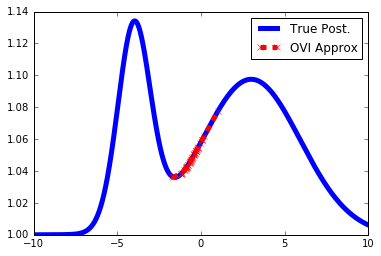

In [29]:
nEpochs = 200
lr = 10.

for epoch_idx in xrange(nEpochs):
    #print "OVI Obj: %f" %(opVI_obj_qUpdate(qParams))
    grad_q_params = dObj_qUpdate(qParams)
    grad_f_params = dObj_fUpdate(fParams)
    qParams -= lr * grad_q_params
    fParams -= lr * grad_f_params
        
# true post
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logPost(x, postParams)) for x in x_true]

# approx learned by q
nSamples = 50
x_samples = [q_forwardProp(qParams, np.random.normal(size=(1,10)))[0,0] for idx in xrange(nSamples)]
x_samples.sort()
probs_approx = [np.exp(logPost(x, postParams)) for x in x_samples]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True Post.")
plt.plot(x_samples, probs_approx, 'rx--', linewidth=5, label="OVI Approx")
plt.xlim([-10,10])
plt.legend()